# Assholery Highlights
## Showcasing the best models for each section from the `2B. Classification - Assholery (FULL)` notebook

## Table of Contents:
### [Reading In Data](#r/AmITheAsshole)
### [Part 1 Highlights: Using `op_text`](#Part-One) and [Results](#Part-One-(op_text)-Best-Results)
### [Part 2 Highlights: Using `comments`](#Part-Two) and [Results](#Part-Two-(comments)-Best-Results)
### [Part 3 Highlights: Using `op_text` and `comments`](#Part-Three) and [Results](#Part-Three-(all_text)-Best-Results)
### [Overall Findings](#Conclusion)

## Imports

In [1]:
import pandas as pd
import numpy as np
import operator

import nltk
import regex as re
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.metrics import roc_curve, auc

from IPython.display import display, Markdown
import matplotlib.pyplot as plt

## Library

In [2]:
def get_verdict(all_comments):
    """
    Counts up all of the judgements (using the subreddit's rules; must be all-caps for their bot to pick it up)
    and gets the verdict for the given post.
    Returns the verdict (the judgement with the most votes) and a dictionary of all the votes by option.
    """
    opinions = {
        'NTA':0,
        'YTA':0,
        'ESH':0,
        'NAH':0,
        'INFO':0,
        'YWBTA':0
    }
    
    for option in opinions.keys():
        opinions[option] = all_comments.count(option)
    
    return list(sorted(opinions.items(), key=operator.itemgetter(1), reverse=True))[0][0], opinions

In [3]:
def remove_automod(comms):
    """
    Removes the automod comment(s) that are pinned to the top of the post
    (meaning they're always at the beginning of the string of concatenated comments here).
    """
    automod_mess = "(/message/compose/?to=/r/AmItheAsshole) if you have any questions or concerns."
    automod_end = comms.find(automod_mess)
    while automod_end != -1:
        comms = comms[automod_end+len(automod_mess):]
        automod_end = comms.find(automod_mess)
    return comms

In [4]:
def remove_judgements(text):
    """
    Removes any variation of the common judgements in the text of the comments, because leaving that in would be
    a dead giveaway to the classifier.
    """
    to_remove = ['Wibta', 'Aita', 'Nta', 'Esh', 'Yta', 'Ywbta', 'Nah']
    to_remove += [tr.lower() for tr in to_remove]
    to_remove += [tr.upper() for tr in to_remove]
    for tr in to_remove:
        text = text.replace(tr, "")
    return text

In [5]:
def clean_post(post):
    """
    Does basic cleaning of the text. Removes non-alphabetical characters and transforms to lowercase.
    """
    return " ".join(re.sub("[^a-zA-Z]", " ", str(post)).lower().split())

In [6]:
def performance_metrics(y_test, preds):
    """
    Takes in actual y-values and predicted y-values and prints out two Markdown tables:
    a formatted confusion matrix; and a table of five computed classification metrics.
    """
    display(Markdown('#### Confusion Matrix'))
    display(pd.DataFrame(confusion_matrix(y_test, preds), columns=['predicted NTA', 'predicted TA'],
            index=['actual NTA', 'actual TA']))
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    
    accuracy = round(((tn + tp) / (tn + tp + fn + fp)), 3)
    
    precision = round((tp / (tp + fp)), 3)
    
    sensitivity = round((tp / (tp + fn)), 3)
    
    specificity = round((tn / (tn + fp)), 3)
    
    misclassification_rate = round(((fp + fn) / (tn + tp + fn + fp)), 3)
    
    performance = f"""| Metric  | Score
|--------|--------------------
| Accuracy | {accuracy} |
| Precision | {precision} |
| Sensitivity | {sensitivity} |
| Specificity | {specificity} |
| Misclassification Rate | {misclassification_rate} |"""
    
    display(Markdown('#### Performance Metrics'))
    display(Markdown(performance))

In [7]:
# Making a scorer to pass in to GridSearchCV() when I want to compare based on this instead of on accuracy score.
# FIXED: needs_proba=True, affects how the scorer is instantiated and what happens inside the GridSearch
# (remember the stackoverflow question about this exact problem)
roc_auc = make_scorer(roc_auc_score, needs_proba=True)

In [8]:
def plot_roc_auc(fpr, tpr, thresholds):
    """
    Plots out the ROC curve and AUC.
    (adapted from sklearn documentation example)
    """
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC Curve')
    plt.legend(loc="lower right")
    plt.show()

In [9]:
def gs_pipe_performance(gspipe, X_train, X_test, y_train, y_test):
    """
    Prints out a number of informative messages about a GridSearchCV object after it has been fit.
    Includes: best score, best params (for the best estimator), training and test scores, the scorer,
    the baseline (i.e., normalized actual y-value counts), and also calls performance_metrics().
    Also calculates and plots out the ROC curve and AUC (by calling plot_roc_auc()).
    """
    print("Best score:", gspipe.best_score_)
    print()
    print("Best params:")
    for k, v in gspipe.best_params_.items():
        print("\t"+k, v)
        print()
    print()
    print("Training score:", gspipe.score(X_train, y_train))
    print("Test score:", gspipe.score(X_test, y_test))
    print("Scorer:", gspipe.scorer_)
    print()
    print("Baseline:")
    print(y_test.value_counts(normalize=True))
    print()
    preds = gspipe.predict(X_test)
    print(preds[:20])
    performance_metrics(y_test, preds)
    pred_probas_pos = gspipe.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, pred_probas_pos)
    plot_roc_auc(fpr, tpr, thresholds)
    print(roc_auc_score(y_test, pred_probas_pos))


## r/AmITheAsshole
[**return to top of notebook**](#Table-of-Contents:)

In [10]:
# aita = pd.read_csv('./datasets/with_comments/r_AmITheAsshole_with_comments.csv')
aita = pd.read_csv('/Users/shreya/DSI/projects/project_3fake/datasets/with_comments/r_AmITheAsshole_with_comments.csv')
print(aita.shape)
for c in aita.columns:
    print(c, aita[c].dtype)
print(aita.isnull().sum())
aita.head()

(2002, 4)
id object
title object
selftext object
comments object
id          0
title       0
selftext    0
comments    0
dtype: int64


,id,title,selftext,comments
0,dgjarh,AITA for not wanting my dads new gf to sing at...,So I (28F) am getting married next year. \n\nI...,\nIf you want your comment to count toward jud...
1,dgjgap,AITA for “looking poor”?,Soo my family used to be really poor but my pa...,\nIf you want your comment to count toward jud...
2,dgjvfw,AITA for calling my family out on their eating...,"My brother is 15, turning 16 soon. He gets no...",\nIf you want your comment to count toward jud...
3,dgk74h,AITA for using the street parking in front of ...,I strongly dislike my neighbors and that is ma...,\nIf you want your comment to count toward jud...
4,dgkgu6,AITA for refusing to cook my boyfriends steak ...,I’ve been with my boyfriend for a couple years...,\nIf you want your comment to count toward jud...


In [11]:
aita['verdict'], aita['opinions'] = zip(*aita['comments'].apply(get_verdict))
aita['verdict'].value_counts()

NTA      1547
YTA       375
NAH        54
ESH        25
YWBTA       1
Name: verdict, dtype: int64

In [12]:
aita['is_TA'] = aita['verdict'].map({
    'YTA':1,
    'ESH':-1,
    'NTA':0,
    'NAH':-1,
    'YWBTA':-1
})
aita['is_TA'].value_counts()

 0    1547
 1     375
-1      80
Name: is_TA, dtype: int64

In [13]:
aita = aita.loc[aita['is_TA'] != -1].copy()
print(aita['is_TA'].value_counts())
print()
print(aita['is_TA'].value_counts(normalize=True))

0    1547
1     375
Name: is_TA, dtype: int64

0    0.804891
1    0.195109
Name: is_TA, dtype: float64


In [14]:
aita.shape

(1922, 7)

In [15]:
aita['clean_comments'] = aita['comments'].map(remove_automod)
aita['clean_comments'] = aita['clean_comments'].map(remove_judgements)
aita['clean_op_text'] = aita['title'].map(remove_judgements) + " " + aita['selftext']

In [16]:
aita.head()

,id,title,selftext,comments,verdict,opinions,is_TA,clean_comments,clean_op_text
0,dgjarh,AITA for not wanting my dads new gf to sing at...,So I (28F) am getting married next year. \n\nI...,\nIf you want your comment to count toward jud...,NTA,"{'NTA': 82, 'YTA': 1, 'ESH': 1, 'NAH': 1, 'INF...",0,*\n\n\n. It's your wedding and she's a strange...,for not wanting my dads new gf to sing at my ...
1,dgjgap,AITA for “looking poor”?,Soo my family used to be really poor but my pa...,\nIf you want your comment to count toward jud...,YTA,"{'NTA': 52, 'YTA': 142, 'ESH': 10, 'NAH': 21, ...",1,"*\n, you offered to pay them back, and they tu...",for “looking poor”? Soo my family used to be ...
2,dgjvfw,AITA for calling my family out on their eating...,"My brother is 15, turning 16 soon. He gets no...",\nIf you want your comment to count toward jud...,NTA,"{'NTA': 66, 'YTA': 8, 'ESH': 10, 'NAH': 3, 'IN...",0,*\n. It's nice that you're trying to help but ...,for calling my family out on their eating hab...
3,dgk74h,AITA for using the street parking in front of ...,I strongly dislike my neighbors and that is ma...,\nIf you want your comment to count toward jud...,NTA,"{'NTA': 45, 'YTA': 5, 'ESH': 7, 'NAH': 1, 'INF...",0,*\n. If she has a problem with a legally parke...,for using the street parking in front of my n...
4,dgkgu6,AITA for refusing to cook my boyfriends steak ...,I’ve been with my boyfriend for a couple years...,\nIf you want your comment to count toward jud...,YTA,"{'NTA': 53, 'YTA': 64, 'ESH': 32, 'NAH': 7, 'I...",1,*\n.\n\nHe could have cooked his own before th...,for refusing to cook my boyfriends steak rare...


## Part One

### Based on `op_text`, can I predict the verdict/`is_TA`? [Jump to section results.](#Part-One-(op_text)-Best-Results)

[**return to top of notebook**](#Assholery-Highlights)

In [17]:
aita.shape

(1922, 9)

In [18]:
df = aita[['clean_op_text', 'is_TA']].copy()
df.shape

(1922, 2)

In [19]:
df.head(3)

,clean_op_text,is_TA
0,for not wanting my dads new gf to sing at my ...,0
1,for “looking poor”? Soo my family used to be ...,1
2,for calling my family out on their eating hab...,0


In [20]:
X = df['clean_op_text'] # must be a vector
print('X:')
print(X.tail())
print()
print()

y = df['is_TA']
print('y:')
print(y.tail())
print()
print('check distribution of y, are the classes unbalanced?')
display(y.value_counts(normalize=True))

print('X:', X.shape, 'y:', y.shape)

X:
1997     for asking my coworker to take allergy medici...
1998     for calling the cops on my roommate's boyfrie...
1999     for wanting my boyfriend to move back in with...
2000     for "faking" an accent so people stop thinkin...
2001     for not helping my mother out financially whe...
Name: clean_op_text, dtype: object


y:
1997    0
1998    0
1999    0
2000    0
2001    0
Name: is_TA, dtype: int64

check distribution of y, are the classes unbalanced?


0    0.804891
1    0.195109
Name: is_TA, dtype: float64

X: (1922,) y: (1922,)


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y, random_state=23)

In [22]:
# baseline
y_test.value_counts(normalize=True)

0    0.804574
1    0.195426
Name: is_TA, dtype: float64

### MultinomialNB() + CountVectorizer() with ROC_AUC Scoring

In [23]:
pipe = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('estimator', LogisticRegression())
])

pipe_params = {
    'vectorizer':[CountVectorizer()],
    'vectorizer__max_features':[100, 500],
    'vectorizer__stop_words':[None, stopwords.words('english')],
    'vectorizer__ngram_range':[(1,2)],
    'estimator':[MultinomialNB()]
}

gs = GridSearchCV(pipe,
                  pipe_params,
                  cv=5,
                  verbose=2,
                  scoring=roc_auc)

In [24]:
%%time

gs.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True), vectorizer=CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None), vectorizer__max_features=100, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True), vectorizer=CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None), vectorizer__max_features=100, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   1.2s
[CV] estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True), vectorizer=CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        token

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV]  estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True), vectorizer=CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None), vectorizer__max_features=100, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   1.0s
[CV] estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True), vectorizer=CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokeni

[CV]  estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True), vectorizer=CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100, min_df=1,
        ngram_range=(1, 2), preprocessor=None,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',... 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None), vectorizer__max_features=100, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselv

[CV]  estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True), vectorizer=CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100, min_df=1,
        ngram_range=(1, 2), preprocessor=None,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',... 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None), vectorizer__max_features=100, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselv

[CV]  estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True), vectorizer=CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100, min_df=1,
        ngram_range=(1, 2), preprocessor=None,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',... 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None), vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   1.1s
[CV] estimator=MultinomialNB(alpha=1.

[CV]  estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True), vectorizer=CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=500, min_df=1,
        ngram_range=(1, 2), preprocessor=None,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',... 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None), vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselv

[CV]  estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True), vectorizer=CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=500, min_df=1,
        ngram_range=(1, 2), preprocessor=None,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',... 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None), vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselv

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   28.0s finished


CPU times: user 28.4 s, sys: 538 ms, total: 29 s
Wall time: 29.2 s


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
       ...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'vectorizer': [CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100, min_df=1,
        ngram_range=(1, 2), preprocessor=None,
        stop_words=[...__ngram_range': [(1, 2)], 'estimator': [MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)]},
       pre_dispatch='2*n_jobs', refit

### after fixing the `roc_auc` scorer

Best score: 0.5974929861565542

Best params:
	estimator MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

	vectorizer CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100, min_df=1,
        ngram_range=(1, 2), preprocessor=None,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',... 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

	vectorizer__max_features 100

	vectorizer__ngram_range (1, 2)

	vectorizer__stop_words ['i', 'me', '

#### Confusion Matrix

,predicted NTA,predicted TA
actual NTA,340,47
actual TA,67,27


#### Performance Metrics

| Metric  | Score
|--------|--------------------
| Accuracy | 0.763 |
| Precision | 0.365 |
| Sensitivity | 0.287 |
| Specificity | 0.879 |
| Misclassification Rate | 0.237 |

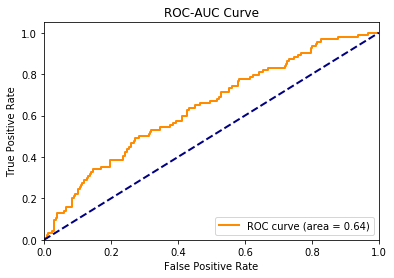

0.640332068832811


In [25]:
gs_pipe_performance(gs, X_train, X_test, y_train, y_test)

### before fixing the `roc_auc` scorer, presumably judged on what was effectively accuracy (based off of calculated ROC at threshold = one point of 0.5)

Best score: 0.563573063770484

Best params:
	estimator MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

	vectorizer CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=500, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

	vectorizer__max_features 500

	vectorizer__ngram_range (1, 2)

	vectorizer__stop_words None


Training score: 0.65171800220886
Test score: 0.5761174336137225
Scorer: make_scorer(roc_auc_score)

Baseline:
0    0.804574
1    0.195426
Name: is_TA, dtype: float64

[0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0]


#### Confusion Matrix

,predicted NTA,predicted TA
actual NTA,273,114
actual TA,52,42


#### Performance Metrics

| Metric  | Score
|--------|--------------------
| Accuracy | 0.655 |
| Precision | 0.269 |
| Sensitivity | 0.447 |
| Specificity | 0.705 |
| Misclassification Rate | 0.345 |

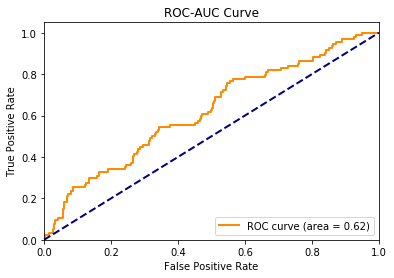

0.6192753862224422


In [25]:
gs_pipe_performance(gs, X_train, X_test, y_train, y_test)

### Part One (`op_text`) Best Results

Before fixing the `auc_roc` scorer, the best was MultinomialNB() with CountVectorizer(max_features=500, stop_words=None, ngram_range=(1,2)).
- AUC-ROC = 0.62
- Accuracy = 0.655
- Precision: 0.269 (0.074 improvement over baseline of 0.195)

**After fixing the `auc_roc` scorer, the best was MultinomialNB() with CountVectorizer(max_features=100, stop_words=stopwords.words('english'), ngram_range=(1,2)).**
- AUC-ROC = 0.64
- Accuracy = 0.763
- **Precision: 0.365 (0.17 improvement over baseline of 0.195)**

| Metric       | Old `auc_roc` Scorer | Fixed `auc_roc` Scorer     |
|--------------|----------------------|----------------------------|
| num_features | 500                  | 100                        |
| stop_words   | None                 | stopwords.words('english') |
| ngram_range  | (1,2)                | (1,2)                      |
| best score   | 0.564                | 0.597                      |
| train score  | 0.652                | 0.698                      |
| test score   | 0.576                | 0.64                       |
| accuracy     | 0.655                | 0.763                      |
| precision    | 0.269                | 0.365                      |
| AUC ROC      | 0.62                 | 0.64                       |

[**return to top of section**](#Part-One)

## Part Two
### Based on `clean_comments`, can I predict the verdict/`is_TA`? [Jump to section results.](#Part-Two-(comments)-Best-Results)

[**return to top of notebook**](#Assholery-Highlights)

In [27]:
aita.shape

(1922, 9)

In [28]:
aita.columns

Index(['id', 'title', 'selftext', 'comments', 'verdict', 'opinions', 'is_TA',
       'clean_comments', 'clean_op_text'],
      dtype='object')

In [29]:
df = aita[['clean_comments', 'is_TA']].copy()

In [30]:
df.shape

(1922, 2)

In [31]:
df.head(3)

,clean_comments,is_TA
0,*\n\n\n. It's your wedding and she's a strange...,0
1,"*\n, you offered to pay them back, and they tu...",1
2,*\n. It's nice that you're trying to help but ...,0


In [32]:
X = df['clean_comments'] # must be a vector
print('X:')
print(X.tail())
print()
print()

y = df['is_TA']
print('y:')
print(y.tail())
print()
print('check distribution of y, are the classes unbalanced?')
display(y.value_counts(normalize=True))

print('X:', X.shape, 'y:', y.shape)

X:
1997    *\n. He gets to decide what medicine he takes,...
1998    *\n. She signed an agreement and he has no rig...
1999    *\n a thousand percent!! Wth is this sugar bab...
2000    *\n as far as I can see. You’ve found a way th...
2001    *\nThey disowned you. They don't get to play t...
Name: clean_comments, dtype: object


y:
1997    0
1998    0
1999    0
2000    0
2001    0
Name: is_TA, dtype: int64

check distribution of y, are the classes unbalanced?


0    0.804891
1    0.195109
Name: is_TA, dtype: float64

X: (1922,) y: (1922,)


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y, random_state=23)

In [34]:
# baseline
y_test.value_counts(normalize=True)

0    0.804574
1    0.195426
Name: is_TA, dtype: float64

### Logistic Regression + CountVectorizer() **with ROC_AUC scoring**

In [35]:
pipe = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('estimator', LogisticRegression())
])

pipe_params = {
        'vectorizer':[CountVectorizer()],
        'vectorizer__max_features':[100, 500],
        'vectorizer__stop_words':[None, stopwords.words('english')],
        'vectorizer__ngram_range':[(1,2)],
        'estimator':[LogisticRegression()]
    }

gs = GridSearchCV(pipe,
                 pipe_params,
                 cv=5,
                 verbose=2,
                 scoring=roc_auc)

In [36]:
%%time

gs.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False), vectorizer=CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None), vectorizer__max_features=100, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/shreya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False), vectorizer=CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None), vectorizer__max_features=100, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=  39.8s
[CV] estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   58.4s remaining:    0.0s
/Users/shreya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False), vectorizer=CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None), vectorizer__max_features=100, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=  39.4s
[CV] estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',


/Users/shreya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False), vectorizer=CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None), vectorizer__max_features=100, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=  39.7s
[CV] estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',


/Users/shreya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False), vectorizer=CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None), vectorizer__max_features=100, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=  43.7s
[CV] estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',


/Users/shreya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False), vectorizer=CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None), vectorizer__max_features=100, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=  45.0s
[CV] estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',


/Users/shreya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False), vectorizer=CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None), vectorizer__max_features=100, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'it

/Users/shreya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False), vectorizer=CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100, min_df=1,
        ngram_range=(1, 2), preprocessor=None,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',... 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"],
        strip_accents=None, token_pattern=

/Users/shreya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False), vectorizer=CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100, min_df=1,
        ngram_range=(1, 2), preprocessor=None,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',... 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"],
        strip_accents=None, token_pattern=

/Users/shreya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False), vectorizer=CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100, min_df=1,
        ngram_range=(1, 2), preprocessor=None,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',... 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"],
        strip_accents=None, token_pattern=

/Users/shreya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False), vectorizer=CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100, min_df=1,
        ngram_range=(1, 2), preprocessor=None,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',... 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"],
        strip_accents=None, token_pattern=

/Users/shreya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False), vectorizer=CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100, min_df=1,
        ngram_range=(1, 2), preprocessor=None,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',... 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"],
        strip_accents=None, token_pattern=

/Users/shreya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False), vectorizer=CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=500, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None), vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=  43.7s
[CV] estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',


/Users/shreya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False), vectorizer=CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=500, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None), vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=  45.9s
[CV] estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',


/Users/shreya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False), vectorizer=CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=500, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None), vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=  44.8s
[CV] estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',


/Users/shreya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False), vectorizer=CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=500, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None), vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=  47.0s
[CV] estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',


/Users/shreya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False), vectorizer=CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=500, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None), vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'it

/Users/shreya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False), vectorizer=CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=500, min_df=1,
        ngram_range=(1, 2), preprocessor=None,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',... 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"],
        strip_accents=None, token_pattern=

/Users/shreya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False), vectorizer=CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=500, min_df=1,
        ngram_range=(1, 2), preprocessor=None,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',... 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"],
        strip_accents=None, token_pattern=

/Users/shreya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False), vectorizer=CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=500, min_df=1,
        ngram_range=(1, 2), preprocessor=None,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',... 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"],
        strip_accents=None, token_pattern=

/Users/shreya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False), vectorizer=CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=500, min_df=1,
        ngram_range=(1, 2), preprocessor=None,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',... 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"],
        strip_accents=None, token_pattern=

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 19.3min finished
/Users/shreya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


CPU times: user 19min 37s, sys: 21.9 s, total: 19min 59s
Wall time: 20min 7s


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
       ...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'vectorizer': [CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=500, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
   ...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)]},
       pre_dispatch='2*n_jobs', refit

### after fixing the `roc_auc` scorer

Best score: 0.7119710364954958

Best params:
	estimator LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

	vectorizer CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=500, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

	vectorizer__max_features 500

	vectorizer__ngram_range (1, 2)

	vectorizer__stop_words None


Training score: 1.0
Test score: 0.7458903733025456
Scorer: make_scorer(roc_auc_score, needs_proba=True)

Baseline:
0    0.804574
1    0.195426
Name: is_TA, dtype: float64

[1 1 0 0 0 0 0 0 0 0 1 0 

#### Confusion Matrix

,predicted NTA,predicted TA
actual NTA,344,43
actual TA,42,52


#### Performance Metrics

| Metric  | Score
|--------|--------------------
| Accuracy | 0.823 |
| Precision | 0.547 |
| Sensitivity | 0.553 |
| Specificity | 0.889 |
| Misclassification Rate | 0.177 |

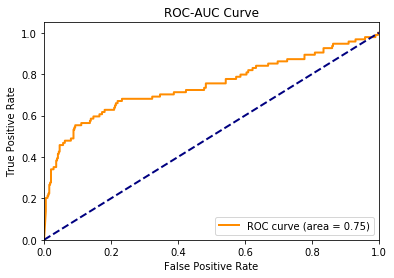

0.7458903733025456


In [37]:
gs_pipe_performance(gs, X_train, X_test, y_train, y_test)

### before fixing the `roc_auc` scorer, presumably judged on what was effectively accuracy (based off of calculated ROC at threshold = one point of 0.5)

Best score: 0.6664847908795416

Best params:
	estimator LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

	vectorizer CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=500, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

	vectorizer__max_features 500

	vectorizer__ngram_range (1, 2)

	vectorizer__stop_words None


Training score: 0.998220640569395
Test score: 0.7276513277255484
Scorer: make_scorer(roc_auc_score)

Baseline:
0    0.804574
1    0.195426
Name: is_TA, dtype: float64

[1 1 0 0 0 0 0 0 0 0 1 0 1 0 

#### Confusion Matrix

,predicted NTA,predicted TA
actual NTA,345,42
actual TA,41,53


#### Performance Metrics

| Metric  | Score
|--------|--------------------
| Accuracy | 0.827 |
| Precision | 0.558 |
| Sensitivity | 0.564 |
| Specificity | 0.891 |
| Misclassification Rate | 0.173 |

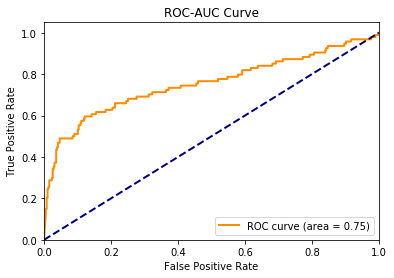

0.7531200175930508


In [36]:
gs_pipe_performance(gs, X_train, X_test, y_train, y_test)

### Part Two (`comments`) Best Results

Before fixing the `auc_roc` scorer, the best was LogisticRegression() with CountVectorizer(max_features=500, stop_words=None, ngram_range=(1,2)). Found with `scoring=auc_roc`.
- AUC-ROC = 0.75
- Accuracy = 0.827
- Precision: 0.558 (0.363 improvement over baseline of 0.195)

**After fixing the `auc_roc` scorer, the best was LogisticRegression() with CountVectorizer(max_features=500, stop_words=None, ngram_range=(1,2)).**
- AUC-ROC = 0.712
- Accuracy = 0.823
**- Precision: 0.547 (0.352 improvement over baseline of 0.195)**

| Metric       | Old `auc_roc` Scorer | Fixed `auc_roc` Scorer |
|--------------|----------------------|------------------------|
| num_features | 500                  | 500                    |
| stop_words   | None                 | None                   |
| ngram_range  | (1,2)                | (1,2)                  |
| best score   | 0.666                | 0.712                  |
| train score  | 0.998                | 1.0                    |
| test score   | 0.728                | 0.746                  |
| accuracy     | 0.827                | 0.823                  |
| precision    | 0.558                | 0.547                  |
| AUC ROC      | 0.75                 | 0.75                   |

[**return to top of section**](#Part-Two)

## Part Three
### Based on `op_text` *and* `clean_comments`, can I predict the verdict/`is_TA`? [Jump to section results.](#Part-Three-(all_text)-Best-Results)

[**return to top of notebook**](#Assholery-Highlights)

In [39]:
aita.shape

(1922, 9)

In [40]:
aita.columns

Index(['id', 'title', 'selftext', 'comments', 'verdict', 'opinions', 'is_TA',
       'clean_comments', 'clean_op_text'],
      dtype='object')

In [41]:
df = aita[['clean_op_text', 'clean_comments', 'is_TA']].copy()
df['clean_comments'] = df['clean_comments'].apply(clean_post)
df.shape

(1922, 3)

In [42]:
df['all_text'] = df['clean_op_text'] + " " + df['clean_comments']
df = df.drop(columns=['clean_op_text', 'clean_comments'])[['all_text', 'is_TA']]
df.head(3)

,all_text,is_TA
0,for not wanting my dads new gf to sing at my ...,0
1,for “looking poor”? Soo my family used to be ...,1
2,for calling my family out on their eating hab...,0


In [43]:
X = df['all_text'] # must be a vector
print('X:')
print(X.tail())
print()
print()

y = df['is_TA']
print('y:')
print(y.tail())
print()
print('check distribution of y, are the classes unbalanced?')
display(y.value_counts(normalize=True))

print('X:', X.shape, 'y:', y.shape)

X:
1997     for asking my coworker to take allergy medici...
1998     for calling the cops on my roommate's boyfrie...
1999     for wanting my boyfriend to move back in with...
2000     for "faking" an accent so people stop thinkin...
2001     for not helping my mother out financially whe...
Name: all_text, dtype: object


y:
1997    0
1998    0
1999    0
2000    0
2001    0
Name: is_TA, dtype: int64

check distribution of y, are the classes unbalanced?


0    0.804891
1    0.195109
Name: is_TA, dtype: float64

X: (1922,) y: (1922,)


In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y, random_state=23)

In [45]:
# baseline
y_test.value_counts(normalize=True)

0    0.804574
1    0.195426
Name: is_TA, dtype: float64

### Best Previous Model - Logistic Regression + CountVectorizer() **with ROC_AUC scoring**

In [47]:
pipe = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('estimator', LogisticRegression())
])

pipe_params = {
        'vectorizer':[CountVectorizer()],
        'vectorizer__max_features':[100, 500],
        'vectorizer__stop_words':[None, stopwords.words('english')],
        'vectorizer__ngram_range':[(1,2)],
        'estimator':[LogisticRegression()]
    }

gs = GridSearchCV(pipe,
                 pipe_params,
                 cv=5,
                 verbose=2,
                 scoring=roc_auc)

In [48]:
%%time

gs.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False), vectorizer=CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None), vectorizer__max_features=100, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/shreya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False), vectorizer=CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None), vectorizer__max_features=100, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=  44.1s
[CV] estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s
/Users/shreya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False), vectorizer=CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None), vectorizer__max_features=100, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=  39.2s
[CV] estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',


/Users/shreya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False), vectorizer=CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None), vectorizer__max_features=100, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=  36.9s
[CV] estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',


/Users/shreya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False), vectorizer=CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None), vectorizer__max_features=100, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=  38.0s
[CV] estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',


/Users/shreya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False), vectorizer=CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None), vectorizer__max_features=100, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=  38.9s
[CV] estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',


/Users/shreya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False), vectorizer=CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None), vectorizer__max_features=100, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'it

/Users/shreya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False), vectorizer=CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100, min_df=1,
        ngram_range=(1, 2), preprocessor=None,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',... 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"],
        strip_accents=None, token_pattern=

/Users/shreya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False), vectorizer=CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100, min_df=1,
        ngram_range=(1, 2), preprocessor=None,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',... 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"],
        strip_accents=None, token_pattern=

/Users/shreya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False), vectorizer=CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100, min_df=1,
        ngram_range=(1, 2), preprocessor=None,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',... 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"],
        strip_accents=None, token_pattern=

/Users/shreya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False), vectorizer=CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100, min_df=1,
        ngram_range=(1, 2), preprocessor=None,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',... 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"],
        strip_accents=None, token_pattern=

/Users/shreya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False), vectorizer=CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100, min_df=1,
        ngram_range=(1, 2), preprocessor=None,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',... 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"],
        strip_accents=None, token_pattern=

/Users/shreya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False), vectorizer=CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=500, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None), vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=  46.7s
[CV] estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',


/Users/shreya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False), vectorizer=CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=500, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None), vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=  50.5s
[CV] estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',


/Users/shreya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False), vectorizer=CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=500, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None), vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=  49.1s
[CV] estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',


/Users/shreya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False), vectorizer=CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=500, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None), vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=  48.7s
[CV] estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',


/Users/shreya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False), vectorizer=CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=500, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None), vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'it

/Users/shreya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False), vectorizer=CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=500, min_df=1,
        ngram_range=(1, 2), preprocessor=None,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',... 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"],
        strip_accents=None, token_pattern=

/Users/shreya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False), vectorizer=CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=500, min_df=1,
        ngram_range=(1, 2), preprocessor=None,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',... 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"],
        strip_accents=None, token_pattern=

/Users/shreya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False), vectorizer=CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=500, min_df=1,
        ngram_range=(1, 2), preprocessor=None,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',... 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"],
        strip_accents=None, token_pattern=

/Users/shreya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False), vectorizer=CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=500, min_df=1,
        ngram_range=(1, 2), preprocessor=None,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',... 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"],
        strip_accents=None, token_pattern=

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 20.6min finished
/Users/shreya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


CPU times: user 20min 49s, sys: 22.9 s, total: 21min 12s
Wall time: 21min 24s


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
       ...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'vectorizer': [CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
   ...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)]},
       pre_dispatch='2*n_jobs', refit

### after fixing the `roc_auc` scorer

Best score: 0.6951290484820776

Best params:
	estimator LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

	vectorizer CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

	vectorizer__max_features 100

	vectorizer__ngram_range (1, 2)

	vectorizer__stop_words None


Training score: 0.826178058657504
Test score: 0.7891033041948431
Scorer: make_scorer(roc_auc_score, needs_proba=True)

Baseline:
0    0.804574
1    0.195426
Name: is_TA, dtype: float64

[0 1 0 0 0 

#### Confusion Matrix

,predicted NTA,predicted TA
actual NTA,362,25
actual TA,64,30


#### Performance Metrics

| Metric  | Score
|--------|--------------------
| Accuracy | 0.815 |
| Precision | 0.545 |
| Sensitivity | 0.319 |
| Specificity | 0.935 |
| Misclassification Rate | 0.185 |

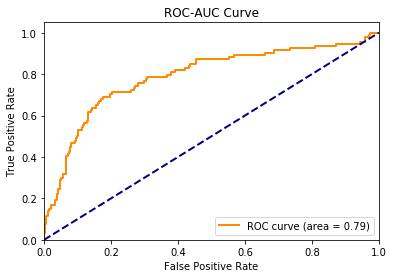

0.7891033041948431


In [49]:
gs_pipe_performance(gs, X_train, X_test, y_train, y_test)

### before fixing the `roc_auc` scorer, presumably judged on what was effectively accuracy (based off of calculated ROC at threshold = one point of 0.5)

Best score: 0.6762145813575552

Best params:
	estimator LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

	vectorizer CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=500, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

	vectorizer__max_features 500

	vectorizer__ngram_range (1, 2)

	vectorizer__stop_words None


Training score: 1.0
Test score: 0.7210401891252955
Scorer: make_scorer(roc_auc_score)

Baseline:
0    0.804574
1    0.195426
Name: is_TA, dtype: float64

[1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0]


#### Confusion Matrix

,predicted NTA,predicted TA
actual NTA,344,43
actual TA,42,52


#### Performance Metrics

| Metric  | Score
|--------|--------------------
| Accuracy | 0.823 |
| Precision | 0.547 |
| Sensitivity | 0.553 |
| Specificity | 0.889 |
| Misclassification Rate | 0.177 |

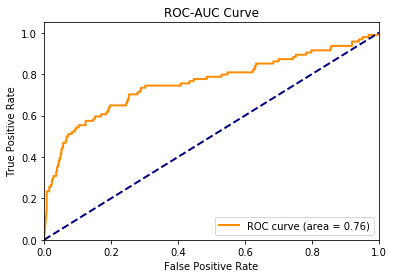

0.7580680631150696


In [46]:
gs_pipe_performance(gs, X_train, X_test, y_train, y_test)

### Part Three (`all_text`) Best Results

Before fixing the `auc_roc` scorer, the best was LogisticRegression() with CountVectorizer(max_features=500, stop_words=None, ngram_range=(1,2)). Found with `scoring=auc_roc`.
- AUC-ROC = 0.76
- Accuracy = 0.823
- Precision: 0.547 (0.352 improvement over baseline of 0.195)

**After fixing the `auc_roc` scorer, the best was LogisticRegression() with CountVectorizer(max_features=100, stop_words=None, ngram_range=(1,2)).**
- AUC-ROC = 0.79
- Accuracy = 0.815
- **Precision: 0.545 (0.35 improvement over baseline of 0.195)**

| Metric       	| Old `auc_roc` Scorer 	| Fixed `auc_roc` Scorer 	|
|--------------	|----------------------	|------------------------	|
| num_features 	| 500                  	| 100                    	|
| stop_words   	| None                 	| None                   	|
| ngram_range  	| (1,2)                	| (1,2)                  	|
| best score   	| 0.676                	| 0.695                  	|
| train score  	| 1.0                  	| 0.826                  	|
| test score   	| 0.721                	| 0.789                  	|
| accuracy     	| 0.823                	| 0.815                  	|
| precision    	| 0.547                	| 0.545                  	|
| AUC ROC      	| 0.76                 	| 0.79                   	|

[**return to top of section**](#Part-Three)

## Conclusion

I've added tables comparing my results from before fixing the `auc_roc` scorer (so back when it was presumably just calculating based off of predictions of 0 or 1 at a single threshold of 0.5, effectively an accuracy score) and after fixing the `auc_roc` scorer (when it's actually calculating based off of the predicted probabilities). This is mainly just to satisfy my own curiosity about whether it would change the results or not -- and it does, in some cases (mainly the vectorizer hyperparameters).

This does raise some more questions about which model to select as the best -- e.g., for Part Two, the returned best model after grid-searching with the `auc_roc` scorer performs marginally worse on both accuracy and precision, and has the same AUC ROC score. But I'm not going to dive too deeply into this further at this moment in time.

### Part One:
**After fixing `auc_roc` scorer, the best model is MultinomialNB() with CountVectorizer(max_features=100, stop_words=stopwords.words('english'), ngram_range=(1,2)).**
- AUC-ROC = 0.64
- Accuracy = 0.763
- **Precision: 0.365 (0.17 improvement over baseline of 0.195)**

| Metric       | Old `auc_roc` Scorer | Fixed `auc_roc` Scorer     |
|--------------|----------------------|----------------------------|
| num_features | 500                  | 100                        |
| stop_words   | None                 | stopwords.words('english') |
| ngram_range  | (1,2)                | (1,2)                      |
| best score   | 0.564                | 0.597                      |
| train score  | 0.652                | 0.698                      |
| test score   | 0.576                | 0.64                       |
| accuracy     | 0.655                | 0.763                      |
| precision    | 0.269                | 0.365                      |
| AUC ROC      | 0.62                 | 0.64                       |

### Part Two:
**After fixing `auc_roc` scorer, the best model is LogisticRegression() with CountVectorizer(max_features=500, stop_words=None, ngram_range=(1,2)).**
- AUC-ROC = 0.75
- Accuracy = 0.823
- **Precision: 0.547 (0.352 improvement over baseline of 0.195)**

| Metric       | Old `auc_roc` Scorer | Fixed `auc_roc` Scorer |
|--------------|----------------------|------------------------|
| num_features | 500                  | 500                    |
| stop_words   | None                 | None                   |
| ngram_range  | (1,2)                | (1,2)                  |
| best score   | 0.666                | 0.712                  |
| train score  | 0.998                | 1.0                    |
| test score   | 0.728                | 0.746                  |
| accuracy     | 0.827                | 0.823                  |
| precision    | 0.558                | 0.547                  |
| AUC ROC      | 0.75                 | 0.75                   |

### Part Three:
**After fixing `auc_roc` scorer, the best model is LogisticRegression() with CountVectorizer(max_features=100, stop_words=None, ngram_range=(1,2)).**
- AUC-ROC = 0.79
- Accuracy = 0.815
- **Precision: 0.545 (0.35 improvement over baseline of 0.195)**

| Metric       	| Old `auc_roc` Scorer 	| Fixed `auc_roc` Scorer 	|
|--------------	|----------------------	|------------------------	|
| num_features 	| 500                  	| 100                    	|
| stop_words   	| None                 	| None                   	|
| ngram_range  	| (1,2)                	| (1,2)                  	|
| best score   	| 0.676                	| 0.695                  	|
| train score  	| 1.0                  	| 0.826                  	|
| test score   	| 0.721                	| 0.789                  	|
| accuracy     	| 0.823                	| 0.815                  	|
| precision    	| 0.547                	| 0.545                  	|
| AUC ROC      	| 0.76                 	| 0.79                   	|

[**return to top of notebook**](#Assholery-Highlights)